In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import json

# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:,.10f}'.format
%matplotlib inline

# Load the data
# We have this defaulted to the folder OUTSIDE of your repo - please change it as needed
population = pd.read_csv('Population by Age and Sex - US, States, Counties.csv')

def load_json(file_name: str):
    with open(file_name, 'r') as file:
        file_data = json.load(file)
    rows = []
    for person in file_data:
        base_info = {
            "bioguide_id": person["id"].get("bioguide"),
            "govtrack_id": person["id"].get("govtrack"),
            "icpsr_id": person["id"].get("icpsr"),
            "wikipedia": person["id"].get("wikipedia"),
            "wikidata": person["id"].get("wikidata"),
            "first_name": person["name"]["first"],
            "last_name": person["name"]["last"],
            "gender": person["bio"].get("gender"),
            "birthday": person["bio"].get("birthday"),
        }
        for term in person["terms"]:
            row = base_info.copy()
            row.update({
                "type": term["type"],
                "start": term["start"],
                "end": term["end"],
                "state": term["state"],
                "district": term.get("district"),
                "party": term.get("party"),
                "class": term.get("class"),
            })
            rows.append(row)

    # Convert to DataFrame
    legislators = pd.DataFrame(rows)
    return legislators

# load both historical & current into dataframes
incumbent = load_json('legislators-current.json')
non_incumbent = load_json('legislators-historical.json')

In [5]:
# Congress members with birthyear from 1900
non_incumbent['birthday'] = pd.to_datetime(non_incumbent['birthday'])
non_incumbent = non_incumbent[non_incumbent['birthday'].dt.year >= 1900]

incumbent['birthday'] = pd.to_datetime(incumbent['birthday'])
incumbent = incumbent[incumbent['birthday'].dt.year >= 1900]

# Convert terms start and end to datetime
incumbent['start'] = pd.to_datetime(incumbent['start'])
incumbent['end'] = pd.to_datetime(incumbent['end'])
non_incumbent['start'] = pd.to_datetime(non_incumbent['start'])
non_incumbent['end'] = pd.to_datetime(non_incumbent['end'])

# Descrtiptive Analysis - How can I summarize these data?
# There are duplicates here as each candidate can have multiple entries


def group_party(df):
    party_count = df.groupby(['party']).agg(
        party_count=('party', 'count'),
    ).reset_index()
    return party_count


def group_chamber(df):
    chamber_count = df.groupby(['chamber']).agg(
        chamber_count=('chamber', 'count'),
    ).reset_index()
    return chamber_count

# incumbent_party = group_party(incumbent)
# non_incumbent_party = group_party(non_incumbent)
# print(incumbent_party)
# print(non_incumbent_party)

# Need to figure out age from birthday to end_terms since non_incumbents will be way dead


def group_age(df):
    df['age'] = df['birthday'].apply(
        lambda x: min((datetime.now() - pd.to_datetime(x)).days // 365, 100))

    # Group by party and calculate age statistics
    age_summary = df.groupby(['party', 'type', 'gender']).agg(
        average_age=('age', 'mean'),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    # Format average_age to 2 decimal points without trailing zeros
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary
# inc_age = group_age(incumbent)
# noninc_age = group_age(non_incumbent)
# print(f'Incumbent:\n {inc_age}')
# print(f'Non-incumbent:\n {noninc_age}')


def group_gender(df):
    gender_count = df.groupby(['party', 'gender']).agg(
        count=('gender', 'count')
    ).reset_index()
    return gender_count
# incumbent_gender = group_gender(incumbent)
# non_incumbent_gender = group_gender(non_incumbent)
# print(incumbent_gender)
# print(non_incumbent_gender)


def group_years_of_service(df):
    df['years_of_service'] = (pd.to_datetime(
        df['end']) - pd.to_datetime(df['start'])).dt.days // 365

    # Group by party and calculate years of service statistics
    service_summary = df.groupby('party').agg(
        total_years=('years_of_service', 'sum'),
        average_years=('years_of_service', 'mean'),
        min_years=('years_of_service', 'min'),
        max_years=('years_of_service', 'max'),
    ).reset_index()
    return service_summary
# inc_years = group_years_of_service(incumbent)
# noninc_years = group_years_of_service(non_incumbent)
# print(noninc_years)

# Bioguide is duplicates since one candidate can serve multiple terms


def group_state_party(df):
    state_party_count = df.groupby(['state', 'party', 'type']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()
    return state_party_count

# inc_sp = group_state_party(incumbent)
# print(inc_sp)


def group_dates(df):
    date_summary = df.groupby('party').agg(
        average_start=('start', lambda x: pd.to_datetime(x).mean()),
        median_start=('start', lambda x: pd.to_datetime(x).median()),
        average_end=('end', lambda x: pd.to_datetime(x).mean()),
        median_end=('end', lambda x: pd.to_datetime(x).median()),
    ).reset_index()
    return date_summary
# inc_dates = group_dates(incumbent)


def group_decade(df):
    # Add a "start_decade" column
    df['start_decade'] = pd.to_datetime(df['start']).dt.year // 10 * 10
    # Group by decade and party
    decade_summary = incumbent.groupby(['start_decade', 'party']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()
    return decade_summary

# inc_decade = group_decade(incumbent)
# inc_decade


def group_top_states(df):
    top_states = df.groupby(['state', 'party', 'type']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()
    # Sort and find the top states for each party
    top_states = top_states.sort_values(
        ['party', 'legislator_count'], ascending=[True, False])
    return top_states

# inc_top_states = group_top_states(incumbent)
# inc_top_states
# print(incumbent.info())

# When did they get there?


def group_age_start(df):
    # Calculate age at term start
    df['age_at_start'] = df.apply(
        lambda row: (row['start'] - row['birthday']).days // 365, axis=1)
    # Group by start date and calculate average age
    avg_age_by_term = df.groupby('start').agg(
        average_age=('age_at_start', 'mean')
    ).reset_index()
    avg_age_by_term['average_age'] = avg_age_by_term['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return avg_age_by_term

# inc_avg_start = group_age_start(incumbent)
# inc_avg_start


def age_by_party(df):
    age_summary = df.groupby('party').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary


def age_by_chamber(df):
    age_summary = df.groupby('chamber').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary


def age_by_gender(df):
    age_summary = df.groupby('gender').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary


def age_by_all(df):
    age_summary = df.groupby(['party', 'chamber', 'gender']).agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary


def gender_by_party(df):
    # Group by party and gender, then count
    gender_party_counts = df.groupby(
        ['party', 'gender']).size().reset_index(name='count')
    # Calculate total counts for each party
    total_by_party = gender_party_counts.groupby(
        'party')['count'].transform('sum')
    # Add a proportion column
    gender_party_counts['proportion'] = gender_party_counts['count'] / \
        total_by_party
    return gender_party_counts


def gender_by_chamber(df):
    # Group by chamber and gender, then count
    gender_chamber_counts = df.groupby(
        ['chamber', 'gender']).size().reset_index(name='count')
    # Calculate total counts for each chamber
    total_by_chamber = gender_chamber_counts.groupby(
        'chamber')['count'].transform('sum')
    # Add a proportion column
    gender_chamber_counts['proportion'] = gender_chamber_counts['count'] / \
        total_by_chamber
    return gender_chamber_counts

In [6]:
"""
    Descriptive Analysis:
"""
# incumbent.shape # 2721 rows
# CONGRESS AGE AND GENDER STATS
incumbent = incumbent.rename(columns={'type': 'chamber'})
incumbent['chamber'] = incumbent['chamber'].replace(
    {'rep': 'House'})
incumbent['chamber'] = incumbent['chamber'].replace(
    {'sen': 'Senate'})

non_incumbent = non_incumbent.rename(columns={'type': 'chamber'})
non_incumbent['chamber'] = non_incumbent['chamber'].replace(
    {'rep': 'House'})
non_incumbent['chamber'] = non_incumbent['chamber'].replace(
    {'sen': 'Senate'})

merged = pd.concat([incumbent, non_incumbent], ignore_index=True)
# print(merged.shape)
grouped_incumbent = merged.groupby('bioguide_id').first().reset_index()
# Incumbent without grouping by bioguide_id have duplicated candidates due to multiple terms
grouped_incumbent.shape  # 539 rows which makes sense for combined House + Senate

# Party Affil Stats - Dems/Repubs
incumbent_party = group_party(grouped_incumbent)
# print(incumbent_party)

# Chamber Stats - House(rep)/Senate(sen)
incumbent_chamber = group_chamber(grouped_incumbent)
# print(incumbent_chamber)

# Add Age column = current date - their birthday
def add_age(df):
    df['age'] = df['birthday'].apply(
        lambda x: (datetime.now() - pd.to_datetime(x)).days // 365)

add_age(grouped_incumbent)
grouped_incumbent.shape

# Age Stats by Party
inc_age_party = age_by_party(grouped_incumbent)
# print(inc_age_party)

# Age Stats by Chamber
inc_age_chamber = age_by_chamber(grouped_incumbent)
# print(inc_age_chamber)

# Age Stats By Gender
inc_age_gender = age_by_gender(grouped_incumbent)
# print(inc_age_gender)

# Age Stats By All
inc_age_all = age_by_all(grouped_incumbent)
print(inc_age_all)

# Gender by Party
inc_gender_party = gender_by_party(grouped_incumbent)
# print(inc_gender_party)

# Gender by Chamber
inc_gender_chamber = gender_by_chamber(grouped_incumbent)
# print(inc_gender_chamber)

               party chamber gender  count average_age median_age  mode_age  \
0                 AL   House      M      1          62         62        62   
1     American Labor   House      M      1         114        114       114   
2       Conservative  Senate      M      1         101        101       101   
3           Democrat   House      F    230        71.7       70.5        48   
4           Democrat   House      M   1259       91.31         93       121   
5           Democrat  Senate      F     22       78.59       74.5        77   
6           Democrat  Senate      M    146       92.67       95.5        96   
7       Farmer-Labor   House      M      1         123        123       123   
8      Ind. Democrat   House      M      3      109.67        108        97   
9        Independent   House      M      3       86.67         83        81   
10       Independent  Senate      M      2          77         77        74   
11           Liberal   House      M      1         1

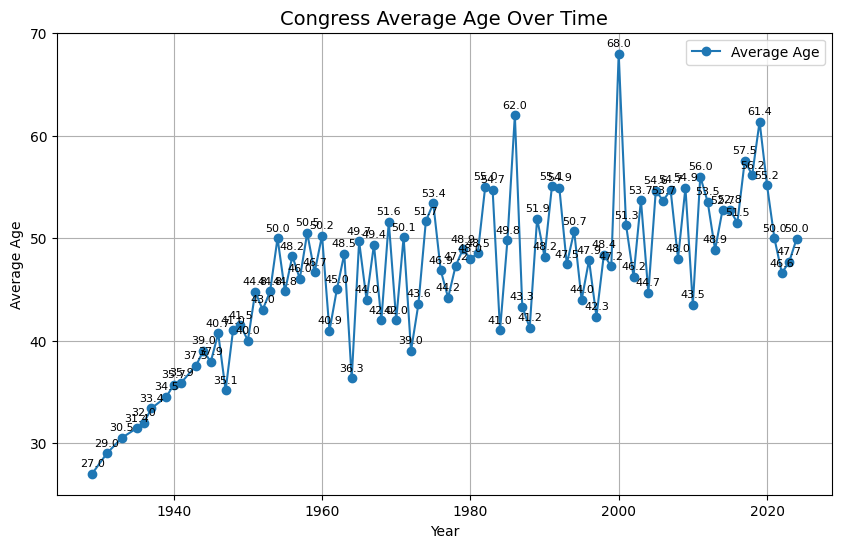

In [7]:
# CONGRESS AGE OVER TIME
# Need to use the entire incumbent dataset to track new cohorts each term
# Compare US Population Age to every new Congress term

inc_avg_over_time = group_age_start(merged)
# inc_avg_over_time = group_age_start(merged)

inc_avg_over_time['year'] = inc_avg_over_time['start'].dt.year
inc_avg_over_time['average_age'] = pd.to_numeric(
    inc_avg_over_time['average_age'], errors='coerce')


inc_avg_over_time = inc_avg_over_time.groupby('year').agg(
    average_age=('average_age', 'mean')
).reset_index()

# print(inc_avg_by_year['avg_age'].dtype)

# Create Line Plot
plt.figure(figsize=(10, 6))
plt.plot(inc_avg_over_time['year'],
         inc_avg_over_time['average_age'], marker='o', label='Average Age')

# Annotate each point with its year and average age
for i, row in inc_avg_over_time.iterrows():
    # Annotate average age slightly below the point
    plt.text(row['year'], row['average_age'] + .5,  # Adjust y-coordinate for average age
             f"{row['average_age']:.1f}", fontsize=8, ha='center', va='bottom')

# Add Labels and Title
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.title('Congress Average Age Over Time', fontsize=14)
plt.legend()
plt.grid(True)

# Show Plot
plt.show()